In [1]:
import numpy as np
import matplotlib.pyplot as plt
from rfi_flagging import RFI_flagging
import helper_functions as hf

## Upload Data

In [2]:
data = []
lst = []
systime = []

year = '2021'
instrument = ['100', '100', '70']
channel = ['EW', 'NS', 'EW']

for ds in range(3):
    path2file = f'../Data/{year}/{instrument[ds]}/{channel[ds]}/'
    file_ending = f'_{year}_{instrument[ds]}{channel[ds]}.npy'
    
    data_temp, lst_temp, sys_temp = hf.upload_data(path2file, file_ending, calib='res50')
    data.append(data_temp)
    lst.append(lst_temp)
    systime.append(sys_temp)

freq = np.linspace(0, 250, 4096)
# initial time across all datasets
t0 = min([systime_ds[0] for systime_ds in systime]) # oct 21 2021 15:13:43 GMT = 18:13:43 local time = 19.769 h LST

### day splits

In [3]:
# split days in LST
day_splits = []
for ds in range(3):
    day_splits.append(hf.split_days(lst[ds]))

In [4]:
# find unix time for day 1 LST=0
i = 1
ds = 2
print(f'somewhere between {int(systime[ds][day_splits[ds][i]-1])} - {int(systime[ds][day_splits[ds][i]])}\n \
(LST {lst[ds][day_splits[ds][i]-1]} - {lst[ds][day_splits[ds][i]]})')

somewhere between 1634844409 - 1634844415
 (LST 23.998845842015903 - 0.0005711472099157336)


In [5]:
# split days in systime
day_1 = 1634844413
s_per_day = 86164.0905 # 3600 * 24 - 3.93*60
day_splits_systime = [np.digitize(systime[ds] - day_1, bins=np.arange(0, s_per_day*100, s_per_day)) for ds in range(3)]

### rfi flag

In [6]:
freq.shape

(4096,)

In [7]:
rfi = []
rfi_freq = []

highpass= [49, 49, 39]
lowpass= [136, 136, 91]
binsize=10
thresh1=8
window=8
thresh2=0.001

for ds in range(3):
    RFI = RFI_flagging(data[ds], freq, lst[ds], systime[ds])
    RFI.truncate(highpass[ds], lowpass[ds]) 
    RFI.lst_flagging(binsize, thresh1)
    RFI.spectral_flagging(window, thresh2)
    RFI.timestream_flagging()
    rfi.append(RFI.data.copy())
    rfi_freq.append(RFI.freq.copy())

/gpfs/fs1/home/s/sievers/nasuyu/.virtualenvs/prizmenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/gpfs/fs1/home/s/sievers/nasuyu/.virtualenvs/prizmenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [8]:
# flag mask
rfi_isnan = [np.isnan(rfi[ds]) for ds in range(3)]

### LST offset

In [9]:
off = 18.75/60
lst_shift = []
for ds in range(3):
    lst_shift.append((lst[ds] + day_splits_systime[ds]*off) % 24)

### visualize

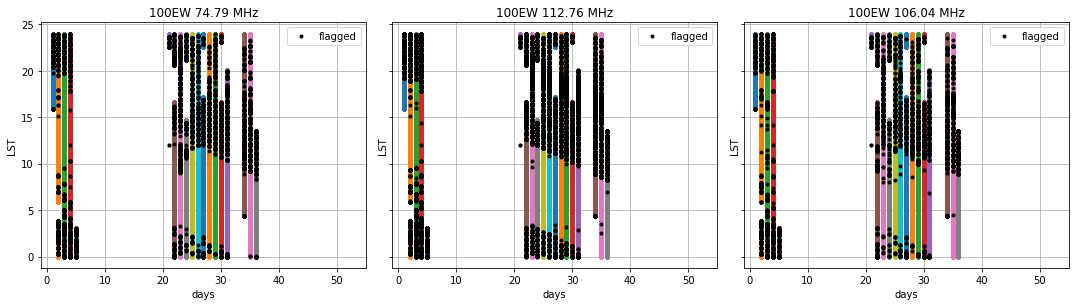

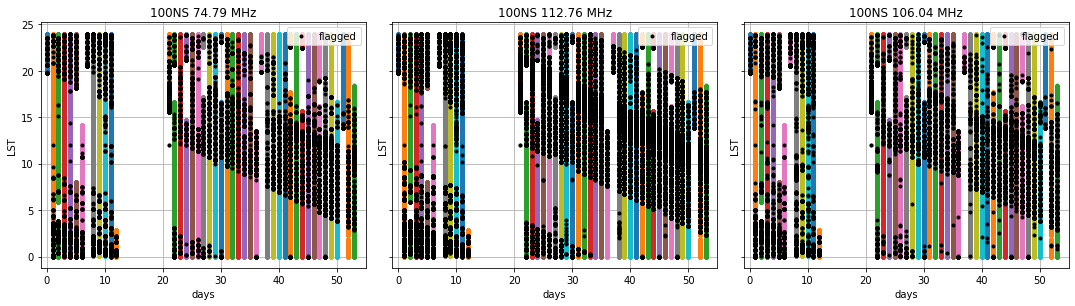

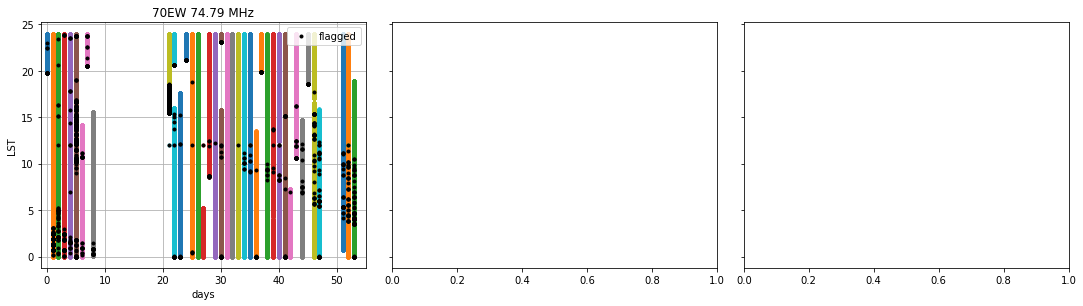

In [40]:
fs = np.array([418, 1040, 930])

for ds in range(3):
    if ds == 2: fs = [fs[0] + 164]
        
    fig = plt.figure(figsize=(15,4))
    ax = fig.subplots(1,3, sharey=True)
    fig.tight_layout()
    for i in range(len(fs)):
        ax[i].grid()
        ax[i].set_ylabel('LST')
        ax[i].set_xlabel('days')
        ax[i].set_xlim(-1,55)
        for d in range(len(day_splits[ds])-1):
            ax[i].plot(day_splits_systime[ds][day_splits[ds][d]:day_splits[ds][d+1]], \
                       lst[ds][day_splits[ds][d]:day_splits[ds][d+1]], '.')
            
    for i, f in enumerate(fs):
        ax[i].set_title(f'{instrument[ds]}{channel[ds]} {round(rfi_freq[ds][f],2)} MHz')
        ax[i].plot(day_splits_systime[ds][rfi_isnan[ds][:, f]], lst[ds][rfi_isnan[ds][:, f]], 'k.', label='flagged')
        ax[i].legend()

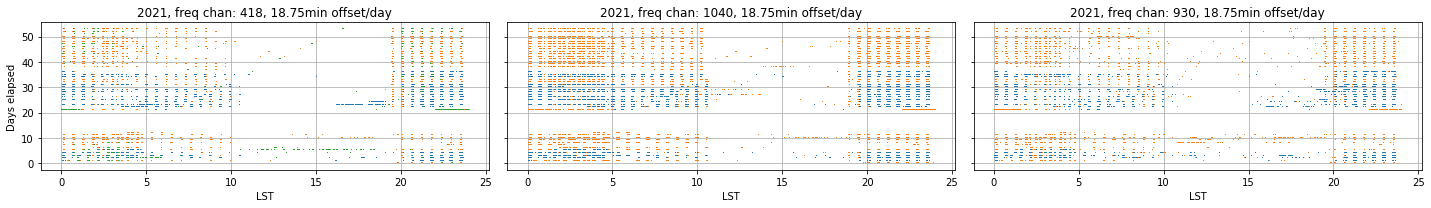

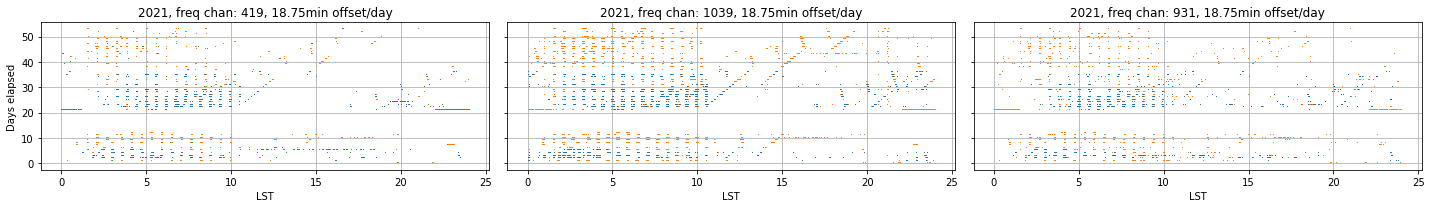

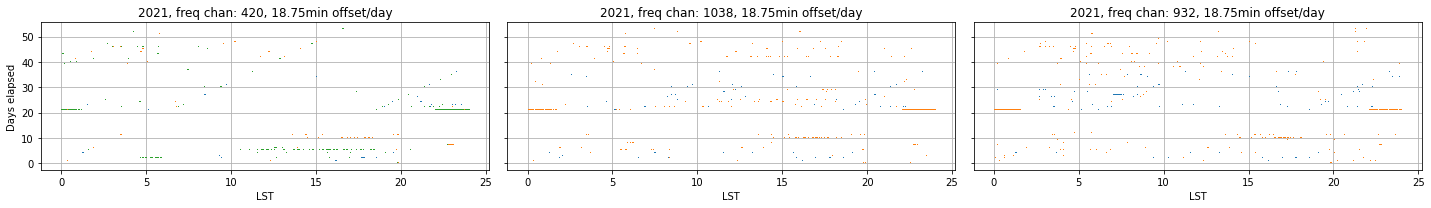

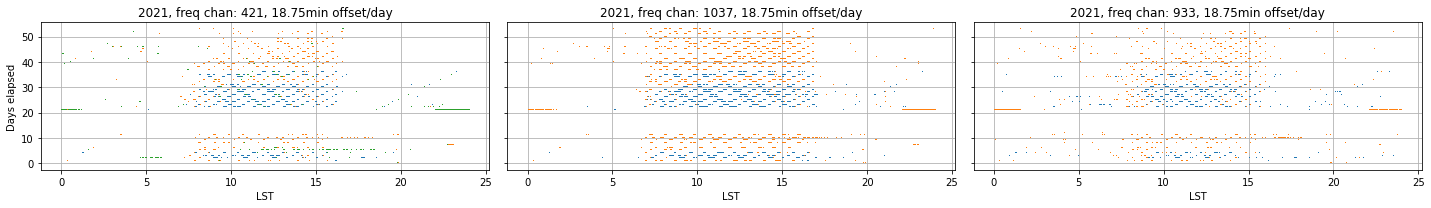

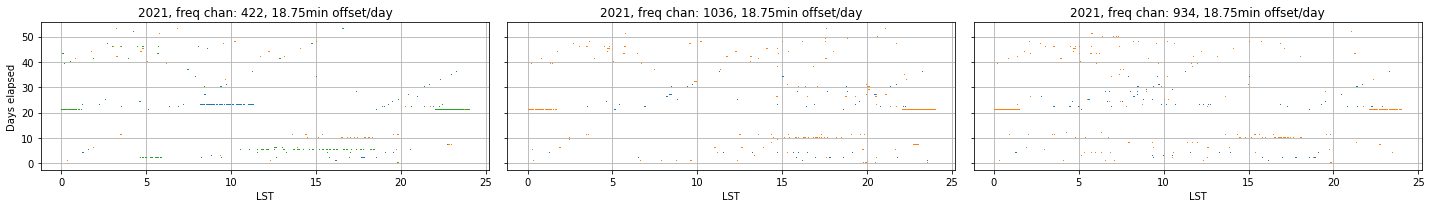

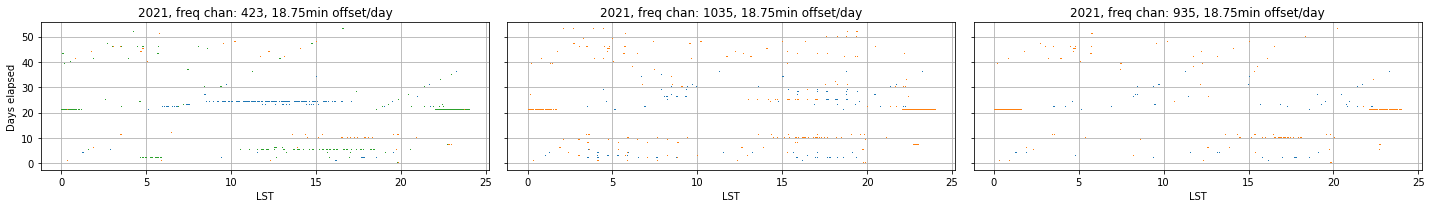

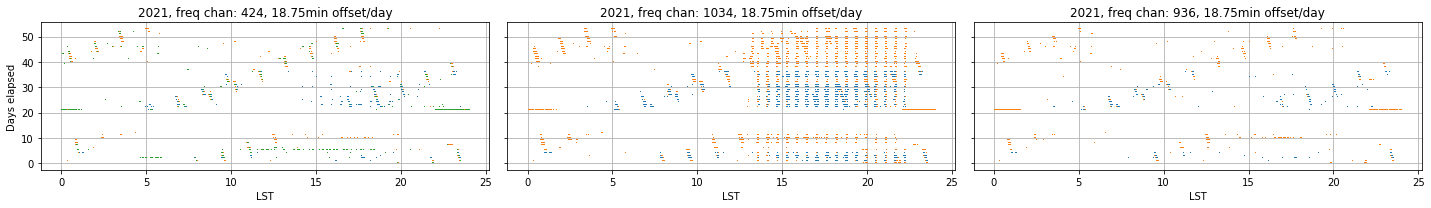

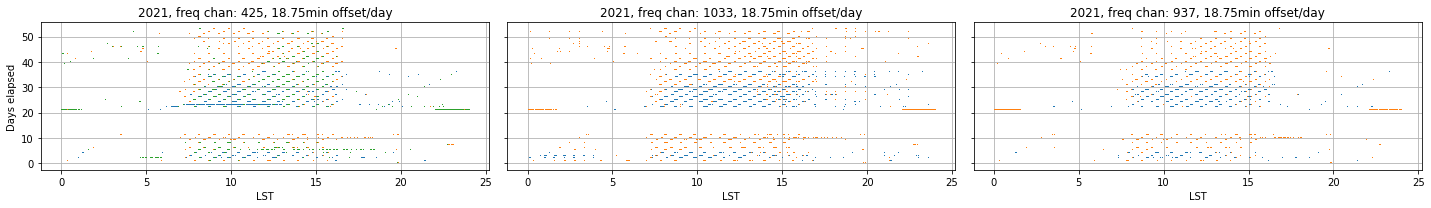

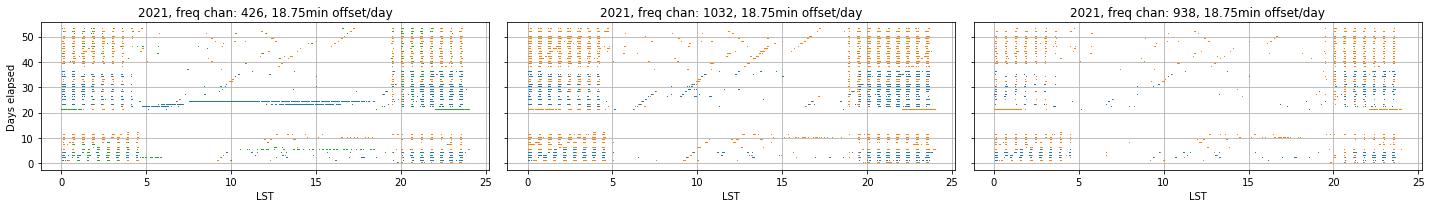

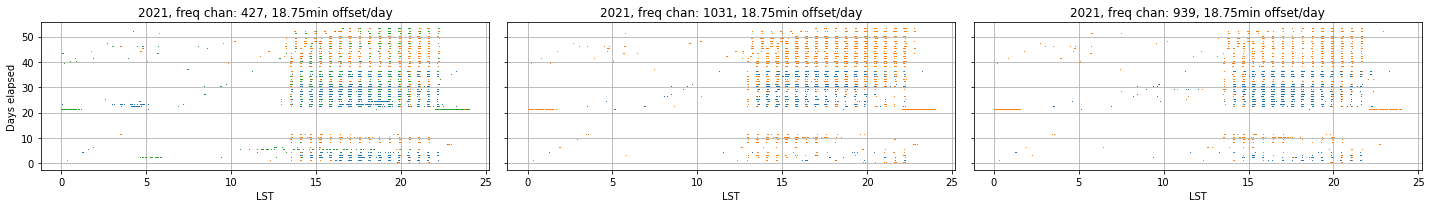

In [39]:
f1 = range(418,428)
f2 = range(930,940)
f3=range(1040, 1030, -1)
fs = [f1,f3,f2]
for fi in range(len(f1)):
    fig = plt.figure(figsize=(20,3))
    ax = fig.subplots(1,3, sharey=True)
    ax[0].set_ylabel('Days elapsed')
    fs = [f1,f3,f2]
    for ii in range(3):
        ax[ii].set_title(f'2021, freq chan: {fs[ii][fi]}, {off*60}min offset/day')
        ax[ii].set_xlabel('LST')
        ax[ii].grid()
        if ii == 0:
            datasets = [1,0,2]
        else:
            datasets = [1,0]
        for ds in datasets:
            for i in range(len(day_splits[ds])-1):
                t1 = day_splits[ds][i]
                t2 = day_splits[ds][i+1]
                if ds == 2:
                    
                    flagged = np.where(rfi_isnan[ds][t1:t2, fs[ii][fi]+164])[0]
                else:
                    flagged = np.where(rfi_isnan[ds][t1:t2, fs[ii][fi]])[0]
                loc_day = day_splits_systime[ds][t1:t2][flagged]
                ax[ii].plot(lst_shift[ds][t1:t2][flagged], np.ones(len(flagged)) * loc_day, ',', color=f'C{ds}')
    plt.tight_layout()
    plt.show()

### build template

In [41]:
binsize = 1/60
bin_inds1 = [np.digitize(lst_shift[ds], bins=np.arange(binsize,24,binsize)) for ds in range(3)]

In [46]:
f = 1040
flag_rate_112 = [(np.sum(rfi_isnan[0][bin_inds1[0] == i, f]) + np.sum(rfi_isnan[1][bin_inds1[1] == i, f])) / \
             (np.sum(bin_inds1[0] == i) + np.sum(bin_inds1[1] == i)) for i in range(1440)]
f = 418
flag_rate_75 = [(np.sum(rfi_isnan[0][bin_inds1[0] == i, f]) + np.sum(rfi_isnan[1][bin_inds1[1] == i, f])) / \
             (np.sum(bin_inds1[0] == i) + np.sum(bin_inds1[1] == i)) for i in range(1440)]
f = 930
flag_rate_106 = [(np.sum(rfi_isnan[0][bin_inds1[0] == i, f]) + np.sum(rfi_isnan[1][bin_inds1[1] == i, f])) / \
             (np.sum(bin_inds1[0] == i) + np.sum(bin_inds1[1] == i)) for i in range(1440)]

In [47]:
thresh = 0.2

template_112 = np.array(flag_rate_112) > thresh
template_75 = np.array(flag_rate_75) > thresh
template_106 = np.array(flag_rate_106) > thresh

template = np.any([template_75, template_106, template_112], axis=0)

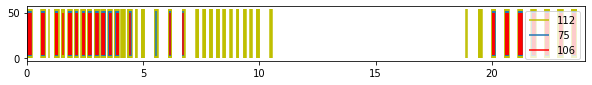

In [48]:
plt.figure(figsize=(10,1))
plt.xlim(0,24)
plt.vlines(np.arange(1440)[template_112] / 60, ymin=0, ymax=54, color='y', label='112')
plt.vlines(np.arange(1440)[template_75] / 60, ymin=2, ymax=52, label='75')
plt.vlines(np.arange(1440)[template_106] / 60, ymin=4, ymax=50, color='r', label='106')
plt.legend()

In [ ]:
np.save('RFI_flagged/templates/template_418_1040_930.npy', np.arange(1440)[template])